# Final project

## Reasearch questions

Which community split is best (born house or married house)?

Compare to the community split obtained by the algorithm.

Which communities are most connected?

Find sentiments score for each community.

Do the most connected communities have similar sentiment scores?

## Loading data


In [ ]:
import pandas as pd
import networkx as nx
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import nltk
import requests
import community
import json

from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS

In [113]:
if (not os.path.exists('files/characters.json')) and (not os.path.exists('files/houses.csv')) and (not os.path.exists('files/wiki_texts/')):
    # create paths
    if not os.path.exists('files'):
        os.mkdir('files')
    if not os.path.exists('files/wiki_texts'):
        os.mkdir('files/wiki_texts')

    baseurl = "https://gameofthrones.fandom.com/api.php?"

    pattern = r'\[{2}(.+?)\]{2}'
    word_pattern = r'\b\w+\b'

    site = 'Game_of_Thrones'
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": site
    }

    # Send the API request to retrieve the content
    response = requests.get(baseurl, params=params)
    data = response.json()

    # Extract and print the text content
    page_id = list(data['query']['pages'].keys())[0]
    text_content = data['query']['pages'][page_id]['revisions'][0]['*']
    cast = text_content[text_content.find("==Cast=="):text_content.find("==Crew==")]
    #print(cast)
    # find all lines starting with *
    lines = cast.split('\n')
    lines = [line for line in lines if line.startswith('*')]
    lines_chars = [line[line.find("as "):] for line in lines]
    # extract the second name in [[name]]
    pattern = r'\[{2}(.+?)\]{2}'
    names = [re.findall(pattern, line)[0] for line in lines_chars]
    names = [name.split('|')[0] for name in names]

    characters = {}
    houses = []
    for name in names:
        print(name)
        params = {
            "action": "query",
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "titles": name
        }

        # Send the API request to retrieve the content
        response = requests.get(baseurl, params=params)
        data = response.json()

        # Extract and print the text content
        page_id = list(data['query']['pages'].keys())[0]
        text_content = data['query']['pages'][page_id]['revisions'][0]['*']
        # save text content to file
        with open('files/wiki_texts/' + name + '.txt', 'w') as f:
            f.write(text_content)
        # find line with | House
        try:
            house_line = re.findall(r'\| House (.+)', text_content)[0]
        except:
            continue
        houses_list = re.findall(pattern, house_line)
        if len(houses_list) == 0:
            continue
        else:
            characters[name] = []
            for house in houses_list:
                house = house.split('|')[0]
                if house == 'Legitimization':
                    continue
                if house == 'House Baratheon of King\'s Landing' or house == 'House Baratheon of Dragonstone':
                    house = 'House Baratheon'
                if house not in houses:
                    houses.append(house)
                if house not in characters[name]:
                    characters[name].append(house)
        print(characters[name])

    with open('files/characters.json', 'w') as fp:
        json.dump(characters, fp)
    # save houses to csv
    houses_df = pd.DataFrame(houses, columns=['House'])
    houses_df.to_csv('files/houses.csv', index=False)
else:
    print('Loading characters and houses from files')
    with open('files/characters.json', 'r') as fp:
        characters = json.load(fp)
    houses_df = pd.read_csv('files/houses.csv')
    houses = list(houses_df['House'])


Eddard Stark
['House Stark']
Catelyn Stark
['House Tully', 'House Stark']
Robb Stark
['House Stark']
Sansa Stark
['House Stark', 'House Lannister', 'House Bolton']
Arya Stark
['House Stark']
Bran Stark
['House Stark']
Rickon Stark
['House Stark']
Jon Snow
['House Targaryen']
Benjen Stark
['House Stark']
Theon Greyjoy
['House Greyjoy']
Rodrik Cassel
['House Cassel']
Jory Cassel
['House Cassel']
Luwin
Hodor
Old Nan
Mordane
Ros
Greatjon Umber
['House Umber']
Smalljon Umber
['House Umber']
Ned Umber
['House Umber']
Rickard Karstark
['House Karstark']
Harald Karstark
['House Karstark']
Alys Karstark
['House Karstark']
Lyanna Mormont
['House Mormont']
Robett Glover
['House Glover']
Cley Cerwyn
['House Cerwyn']
Wyman Manderly
['House Manderly']
Jojen Reed
['House Reed']
Meera Reed
['House Reed']
Roose Bolton
['House Bolton']
Ramsay Bolton
['House Bolton']
Locke
Myranda
Wolkan
Steelshanks
Tywin Lannister
['House Lannister']
Cersei Lannister
['House Lannister', 'House Baratheon']
Jaime Lanniste

In [145]:
if not os.path.exists('files/di_G.gexf'):
    di_G = nx.DiGraph()
    for name in characters:
        houses_list = characters[name]
        houses_string = ', '.join(houses_list)
        di_G.add_node(name, houses=houses_string)

    # add edges
    for name in characters:
        # load text
        with open('files/wiki_texts/' + name + '.txt', 'r') as f:
            text = f.read()
        # extract all links
        links = re.findall(pattern, text)
        # extract all links that are characters
        char_links = [link.split('|')[0] for link in links if link in characters]
        # add edges
        for char_link in char_links:
            di_G.add_edge(name, char_link)

    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))

    nx.write_gexf(di_G, "files/di_G.gexf")
else:
    print('Loading graph from file')
    di_G = nx.read_gexf("files/di_G.gexf")
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))


DiGraph with 114 nodes and 1908 edges
Number of connected components:  1


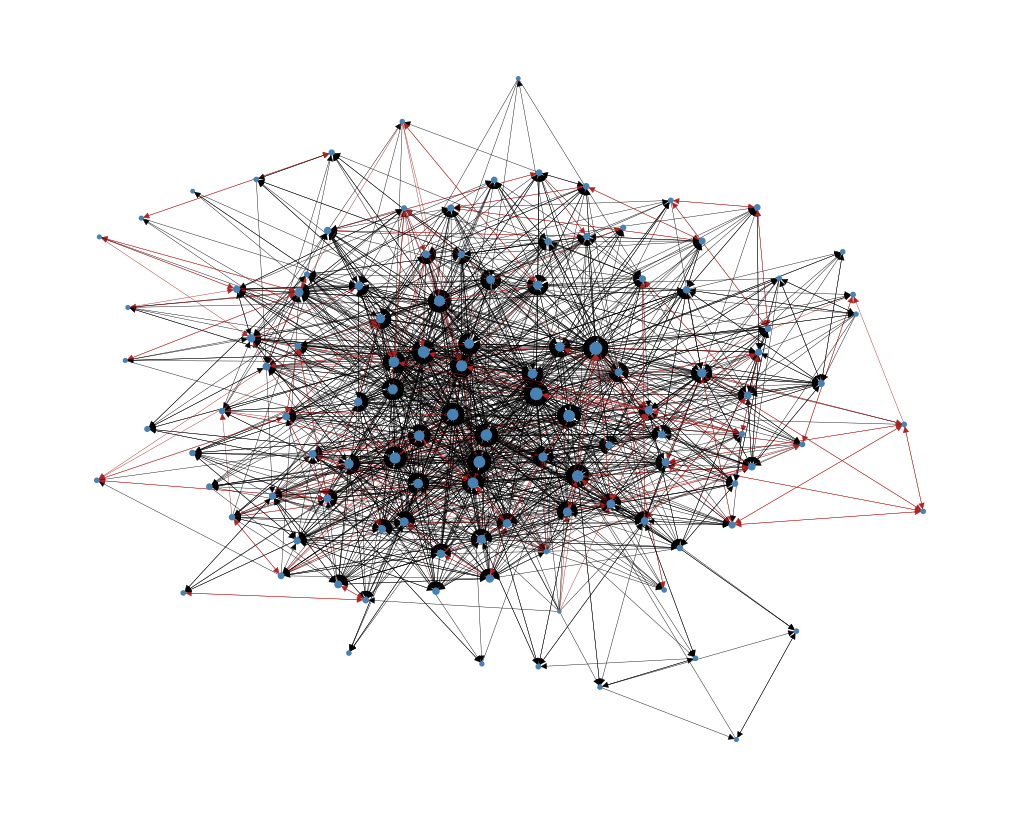

In [153]:
# make a color pallet for the houses
num_houses = len(houses)

node_sizes = [di_G.in_degree(node)+5 for node in di_G]

edge_colors = []
for edge in di_G.edges():
    node_0 = di_G.nodes[edge[0]]
    node_1 = di_G.nodes[edge[1]]
    houses_0 = node_0['houses'].split(', ')
    houses_1 = node_1['houses'].split(', ')

    common_house = False
    for house_0 in houses_0:
        if house_0 in houses_1:
            common_house = True
            break
    
    if common_house:
        edge_colors.append('firebrick')
    else:
        edge_colors.append('black')

color = 'steelblue'

plt.figure(figsize=(10, 8))
nx.draw_kamada_kawai(di_G, node_size=node_sizes, node_color=color, edge_color=edge_colors, width=0.3, with_labels=False)
plt.show()

## Degree distributions

In [154]:
k_in = [di_G.in_degree(node) for node in di_G.nodes()]
k_out = [di_G.out_degree(node) for node in di_G.nodes()]
avg_k_in = np.mean(k_in)
avg_k_out = np.mean(k_out)
avg_k_in_sq = np.mean(np.square(k_in))
avg_k_out_sq = np.mean(np.square(k_out))

print("<k_in>", avg_k_in)
print("<k_out>", avg_k_out)

print("<k_in^2>", avg_k_in_sq)
print("<k_out^2>", avg_k_out_sq)

<k_in> 16.736842105263158
<k_out> 16.736842105263158
<k_in^2> 479.57894736842104
<k_out^2> 414.140350877193


In [160]:
N = len(di_G.nodes())
print(f'lnN = {np.log(N)}')

lnN = 4.736198448394496


min out-degree: 0
max out-degree: 63


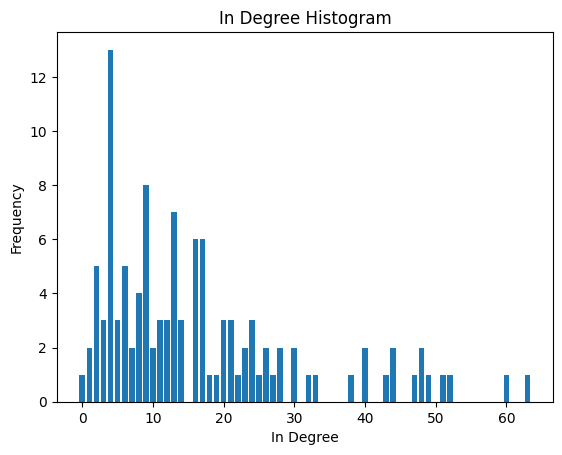

In [155]:
max_k_in = np.max(k_in)
min_k_in = np.min(k_in)
print(f'min out-degree: {min_k_in}')
print(f'max out-degree: {max_k_in}')
v = np.arange(min_k_in,max_k_in+2)

counts_in, bins_in = np.histogram(k_in, bins=v)
sum_counts_in = np.sum(counts_in)
plt.bar(bins_in[:-1], counts_in)

plt.title("In Degree Histogram")
plt.ylabel("Frequency")
plt.xlabel("In Degree")
plt.show()

min out-degree: 2
max out-degree: 49


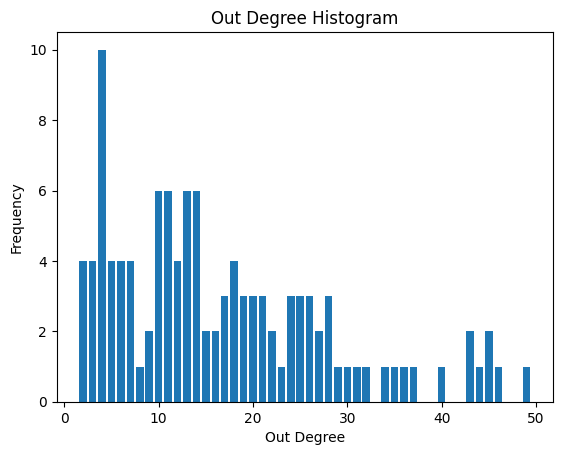

In [156]:
max_k_out = max(k_out)
min_k_out = min(k_out)
print(f'min out-degree: {min_k_out}')
print(f'max out-degree: {max_k_out}')
v = np.arange(min_k_out, max_k_out+2)

counts_out, bins_out = np.histogram(k_out, bins=v)
sum_counts_out = np.sum(counts_out)

plt.bar(bins_out[:-1], counts_out)
plt.title("Out Degree Histogram")
plt.xlabel("Out Degree")
plt.ylabel("Frequency")
plt.show()

In [157]:
# Powerlaw
alpha_in = powerlaw.Fit(k_in).alpha
alpha_out = powerlaw.Fit(k_out).alpha

print(f'alpha in: {alpha_in}')
print(f'alpha out: {alpha_out}')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
alpha in: 2.978870447669684
alpha out: 4.175527666453425


Values less than or equal to 0 in data. Throwing out 0 or negative values
